현재영역 접기 <br>
Ctrl + Shift + [  : Windows and Linux <br>
⌥ + ⌘ + [  : Mac <br>
현재영역 펼치기 <br>
Ctrl + Shift + ]  : Windows and Linux <br>
⌥ + ⌘ + ]  : Mac <br>
전체 접기 <br>
Ctrl + K + 0(숫자)  : Windows and Linux <br>
⌘ + K + 0 (숫자) : Mac <br>
전체 펼치기 <br>
Ctrl + K + J : Windows and Linux <br>
⌘ + K + J : Mac <br>

A : 현재 셀에서 위쪽에 새로운 셀을 추가한다.
B : 현재 셀에서 아래쪽에 새로운 셀을 추가한다.
DD : 현재 셀을 삭제한다.
M : 현재 셀을 코드에서 마크다운으로 변경한다.
Y : 현재 셀을 마크다운에서 코드로 변경한다.
※ 어째선지 바로 가기 키에서는 C가 코드로 변경하는 단축키라고 한다. 무시하자.
C, V, X : 각각 복사, 붙여넣기, 잘라내기이다.

#### Import libraries

In [1]:
import argparse
import datetime
import random
import time
from pathlib import Path
from PIL import Image
import os

import numpy as np
import torch
from torch.utils.data import DataLoader, DistributedSampler
from PIL import Image
import matplotlib.pyplot as plt

# torchvision.ops nms
from torchvision.ops import nms

import datasets
import util.misc as utils
import torchvision.transforms as T

from models import build_model
from datasets.JAXA import make_JAXA_transforms

In [2]:
# 클래스 정의
CLASSES = ['forceps', 'scissors']

COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]


In [3]:
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size, device):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32).to(device)
    return b

def detect(im, model, transform, device): 
    start_time = time.time()

    img = transform(im).unsqueeze(0).to(device)
    outputs = model(img)
    probas = outputs['pred_logits'].softmax(-1)[0, :, 1:]

    # 각 클래스별로 최대 확률과 그에 해당하는 인덱스를 찾음
    max_scores, max_indices = probas.max(dim=0)
    
    # 각 클래스별로 최대 확률이 0.8 이상인 경우만 선택
    keep = (max_scores > 0.8).nonzero(as_tuple=True)[0]
    
    # 선택된 인덱스에 따라 최대 클래스 인덱스와 확률을 유지
    max_indices = max_indices[keep]
    max_scores = max_scores[keep]
    
    # bounding box 스케일링
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size, device)

    # Bounding box 값을 0 이상으로 클리핑
    bboxes_scaled = torch.clamp(bboxes_scaled, min=0)

    # NMS 적용
    if keep.numel() > 0:
        print("bboxes_scaled:", bboxes_scaled)
        print("max_scores:", max_scores)
        keep = nms(bboxes_scaled, max_scores, iou_threshold=0.5)
    else:
        keep = torch.tensor([], dtype=torch.int64, device=device)

    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    
    print(f'Inference time {total_time_str}')
    
    # 선택된 박스에 대한 클래스 확률 반환
    return probas[keep], bboxes_scaled[keep]

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color='blue', linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    
    plt.show(block=False)
    plt.pause(3)
    
    # 창을 자동으로 닫습니다.
    plt.close()
    
# 체크포인트 로드 함수
def load_checkpoint(model, checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location='cuda')
    model.load_state_dict(checkpoint['model'])
    print("Checkpoint loaded successfully.")

In [4]:
def get_args_parser():
    parser = argparse.ArgumentParser('Set transformer detector', add_help=False)
    parser.add_argument('--lr', default=1e-4, type=float)
    parser.add_argument('--lr_backbone', default=1e-5, type=float)
    parser.add_argument('--batch_size', default=2, type=int)
    parser.add_argument('--weight_decay', default=1e-4, type=float)
    parser.add_argument('--epochs', default=300, type=int)
    parser.add_argument('--lr_drop', default=200, type=int)
    parser.add_argument('--clip_max_norm', default=0.1, type=float,
                        help='gradient clipping max norm')

    # Model parameters
    parser.add_argument('--frozen_weights', type=str, default=None,
                        help="Path to the pretrained model. If set, only the mask head will be trained")
    # * Backbone
    parser.add_argument('--backbone', default='resnet50', type=str,
                        help="Name of the convolutional backbone to use")
    parser.add_argument('--dilation', action='store_true',
                        help="If true, we replace stride with dilation in the last convolutional block (DC5)")
    parser.add_argument('--position_embedding', default='sine', type=str, choices=('sine', 'learned'),
                        help="Type of positional embedding to use on top of the image features")

    # * Transformer
    parser.add_argument('--enc_layers', default=6, type=int,
                        help="Number of encoding layers in the transformer")
    parser.add_argument('--dec_layers', default=6, type=int,
                        help="Number of decoding layers in the transformer")
    parser.add_argument('--dim_feedforward', default=2048, type=int,
                        help="Intermediate size of the feedforward layers in the transformer blocks")
    parser.add_argument('--hidden_dim', default=256, type=int,
                        help="Size of the embeddings (dimension of the transformer)")
    parser.add_argument('--dropout', default=0.1, type=float,
                        help="Dropout applied in the transformer")
    parser.add_argument('--nheads', default=8, type=int,
                        help="Number of attention heads inside the transformer's attentions")
    parser.add_argument('--num_queries', default=10, type=int,
                        help="Number of query slots")
    parser.add_argument('--pre_norm', action='store_true')

    # * Segmentation
    parser.add_argument('--masks', action='store_true',
                        help="Train segmentation head if the flag is provided")

    # Loss
    parser.add_argument('--no_aux_loss', dest='aux_loss', action='store_false',
                        help="Disables auxiliary decoding losses (loss at each layer)")
    # * Matcher
    parser.add_argument('--set_cost_class', default=1, type=float,
                        help="Class coefficient in the matching cost")
    parser.add_argument('--set_cost_bbox', default=5, type=float,
                        help="L1 box coefficient in the matching cost")
    parser.add_argument('--set_cost_giou', default=2, type=float,
                        help="giou box coefficient in the matching cost")
    parser.add_argument('--set_cost_pose', default=5, type=float,
                        help="L1 pose coefficient in the matching cost")
    
    # * Loss coefficients
    parser.add_argument('--mask_loss_coef', default=1, type=float)
    parser.add_argument('--dice_loss_coef', default=1, type=float)
    parser.add_argument('--bbox_loss_coef', default=5, type=float)
    parser.add_argument('--giou_loss_coef', default=2, type=float)
    parser.add_argument('--pose_loss_coef', default=5, type=float)
    parser.add_argument('--eos_coef', default=0.1, type=float,
                        help="Relative classification weight of the no-object class")

    # dataset parameters
    parser.add_argument('--dataset_file', default='JAXA')
    parser.add_argument('--data_path', type=str)
    parser.add_argument('--coco_panoptic_path', type=str)
    parser.add_argument('--remove_difficult', action='store_true')

    parser.add_argument('--output_dir', default='',
                        help='path where to save, empty for no saving')
    parser.add_argument('--device', default='cuda',
                        help='device to use for training / testing')
    parser.add_argument('--seed', default=42, type=int)
    parser.add_argument('--resume', default='', help='resume from checkpoint')
    parser.add_argument('--start_epoch', default=0, type=int, metavar='N',
                        help='start epoch')
    parser.add_argument('--eval', action='store_true')
    parser.add_argument('--num_workers', default=8, type=int)

    # distributed training parameters
    parser.add_argument('--world_size', default=1, type=int,
                        help='number of distributed processes')
    parser.add_argument('--dist_url', default='env://', help='url used to set up distributed training')
    return parser

Main

In [5]:
parser = get_args_parser()
args = parser.parse_args()

args.checkpoint = r"F:\YOON\research\detr_pose_jaxa\output\random_30000_epcho_300_noanytransform\checkpoint.pth"

device = torch.device(args.device)
seed = args.seed + utils.get_rank()
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
 
model, _, _ = build_model(args)
model.to(device)

model.eval()

c:\Users\nml\anaconda3\envs\detr_yoon\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nml\anaconda3\envs\detr_yoon\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, ou

In [6]:
load_checkpoint(model, args.checkpoint)

Checkpoint loaded successfully.


In [7]:
transform = T.Compose([
# T.Resize(300),
T.ToTensor(),
T.Normalize([0.3369, 0.3866, 0.4526], [0.1927, 0.2150, 0.2402])
])
img_dir = r'F:\YOON\Datasets\JAXA_dataset\jaxa_100samples_720\images'

n = 0
img_name = os.listdir(img_dir)[n]
img_path = os.path.join(img_dir, img_name)
im = Image.open(img_path)

img = transform(im).unsqueeze(0).to(device)

n += 1

In [8]:
img_name

'1.png'

In [35]:
img.shape

torch.Size([1, 3, 720, 720])

In [36]:
outputs = model(img)
probas = outputs['pred_logits'].softmax(-1)[0, :, 1:]
max_scores, max_indices = probas.max(dim=0)

In [37]:
probas

tensor([[0.0167, 0.9833],
        [0.0157, 0.9843],
        [0.0133, 0.9867],
        [0.3424, 0.6576],
        [0.0135, 0.9865],
        [0.0133, 0.9867],
        [0.0148, 0.9852],
        [0.9905, 0.0095],
        [0.0142, 0.9858],
        [0.0135, 0.9865]], device='cuda:0', grad_fn=<SliceBackward0>)

In [38]:
outputs['pred_boxes']

tensor([[[0.0729, 0.2696, 0.1468, 0.0827],
         [0.0718, 0.2700, 0.1446, 0.0827],
         [0.0712, 0.2697, 0.1434, 0.0830],
         [0.0745, 0.2699, 0.1501, 0.0839],
         [0.0712, 0.2700, 0.1433, 0.0829],
         [0.0713, 0.2699, 0.1435, 0.0829],
         [0.0726, 0.2698, 0.1461, 0.0828],
         [0.8722, 0.3289, 0.2544, 0.0716],
         [0.0712, 0.2696, 0.1433, 0.0829],
         [0.0712, 0.2695, 0.1435, 0.0830]]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [39]:
keep = (max_scores > 0.8).nonzero(as_tuple=True)

In [40]:
keep

(tensor([0, 1], device='cuda:0'),)

In [41]:
outputs = model(img)
probas = outputs['pred_logits'].softmax(-1)[0, :, 1:]

max_scores, max_indices = probas.max(dim=0)
keep = (max_scores > 0.8).nonzero(as_tuple=True)[0]

max_indices = max_indices[keep]
max_scores = max_scores[keep]

bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size, device)
bboxes_scaled = torch.clamp(bboxes_scaled, min=0)

# NMS 적용
if keep.numel() > 0:
    print("bboxes_scaled:", bboxes_scaled)
    print("max_scores:", max_scores)
    keep = nms(bboxes_scaled, max_scores, iou_threshold=0.5)
else:
    keep = torch.tensor([], dtype=torch.int64, device=device)

print("probas[keep]:", probas[keep].shape)
print("bboxes_scaled[keep]:", bboxes_scaled[keep].shape)

bboxes_scaled: tensor([[  0.0000, 164.3469, 105.2957, 223.8911],
        [  0.0000, 164.6367, 103.7307, 224.2162]], device='cuda:0',
       grad_fn=<ClampBackward1>)
max_scores: tensor([0.9905, 0.9867], device='cuda:0', grad_fn=<IndexBackward0>)
probas[keep]: torch.Size([1, 2])
bboxes_scaled[keep]: torch.Size([1, 4])


In [42]:
# 모델 예측
outputs = model(img)
probas = outputs['pred_logits'].softmax(-1)[0, :, 1:]  # 각 클래스에 대한 확률 (배경 제외)

# 각 열(클래스)에서 최대 확률을 구함
max_scores, max_indices = probas.max(dim=0)

# 최대 확률이 0.8 이상인 것만 선택
keep = (max_scores > 0.8).nonzero(as_tuple=True)[0]
max_indices = max_indices[keep]
max_scores = max_scores[keep]

# 바운딩 박스 스케일 조정
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size, device)
bboxes_scaled = torch.clamp(bboxes_scaled, min=0)

# NMS를 적용하지 않고 그대로 유지
if keep.numel() > 0:
    print("bboxes_scaled:", bboxes_scaled)
    print("max_scores:", max_scores)
else:
    keep = torch.tensor([], dtype=torch.int64, device=device)

# 최종 남은 probas와 bboxes 확인
print("probas[keep]:", probas[keep].shape)
print("bboxes_scaled[keep]:", bboxes_scaled[keep].shape)


bboxes_scaled: tensor([[  0.0000, 164.3469, 105.2957, 223.8911],
        [  0.0000, 164.6367, 103.7307, 224.2162]], device='cuda:0',
       grad_fn=<ClampBackward1>)
max_scores: tensor([0.9905, 0.9867], device='cuda:0', grad_fn=<IndexBackward0>)
probas[keep]: torch.Size([2, 2])
bboxes_scaled[keep]: torch.Size([2, 4])


In [43]:
outputs['pred_logits'].shape, outputs['pred_boxes'].shape

(torch.Size([1, 10, 3]), torch.Size([1, 10, 4]))

In [44]:
conv_features, enc_attn_weights, dec_attn_weights = [], [], []

hooks = [
    model.backbone[-2].register_forward_hook(
        lambda self, input, output: conv_features.append(output)
    ),
    model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
        lambda self, input, output: enc_attn_weights.append(output[1]) # output[1] is the attention weights, output[0] is the attention output
    ),
    model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
        lambda self, input, output: dec_attn_weights.append(output[1])
    ),
]

# propagate through the model
outputs = model(img)

for hook in hooks:
    hook.remove()

# don't need the list anymore
conv_features = conv_features[0]
enc_attn_weights = enc_attn_weights[0]
dec_attn_weights = dec_attn_weights[0]

# get the feature map shape
h, w = conv_features['0'].tensors.shape[-2:]

In [45]:
h, w

(23, 23)

In [46]:
conv_features['0'].tensors.shape, enc_attn_weights.shape, dec_attn_weights.shape

(torch.Size([1, 2048, 23, 23]),
 torch.Size([1, 529, 529]),
 torch.Size([1, 10, 529]))

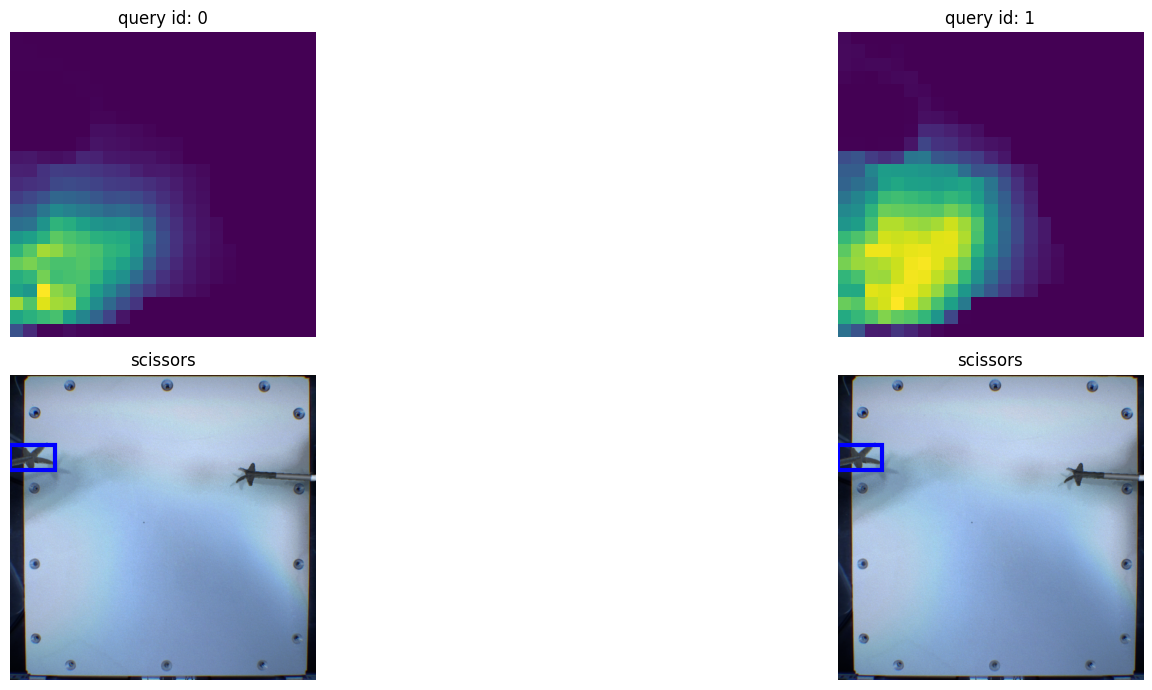

In [47]:
fig, axs = plt.subplots(ncols=len(bboxes_scaled), nrows=2, figsize=(22, 7))
colors = COLORS * 100

# axs가 1D 배열로 생성되었을 가능성에 대비해 2D 배열로 변환
if len(axs.shape) == 1:
    axs = axs.reshape(2, len(bboxes_scaled))

for idx, (xmin, ymin, xmax, ymax), col in zip(keep, bboxes_scaled, range(len(bboxes_scaled))):
    # 상단 행에 어텐션 가중치 이미지 그리기
    ax_top = axs[0, col]  # 첫 번째 행의 Axes
    ax_top.imshow(dec_attn_weights[0, idx].detach().cpu().view(h, w).numpy())
    ax_top.axis('off')
    ax_top.set_title(f'query id: {idx.item()}')

    # 하단 행에 원본 이미지와 바운딩 박스 그리기
    ax_bottom = axs[1, col]  # 두 번째 행의 Axes
    ax_bottom.imshow(im)
    
    # 바운딩 박스 좌표를 CPU로 이동하고 NumPy로 변환
    xmin, ymin, xmax, ymax = xmin.cpu().item(), ymin.cpu().item(), xmax.cpu().item(), ymax.cpu().item()
    ax_bottom.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                      fill=False, color='blue', linewidth=3))
    ax_bottom.axis('off')
    ax_bottom.set_title(CLASSES[probas[idx].argmax()])

fig.tight_layout()
plt.show()


Encoder attention:       torch.Size([529, 529])
Feature map:             torch.Size([1, 2048, 23, 23])
Reshaped self-attention: torch.Size([23, 23, 23, 23])


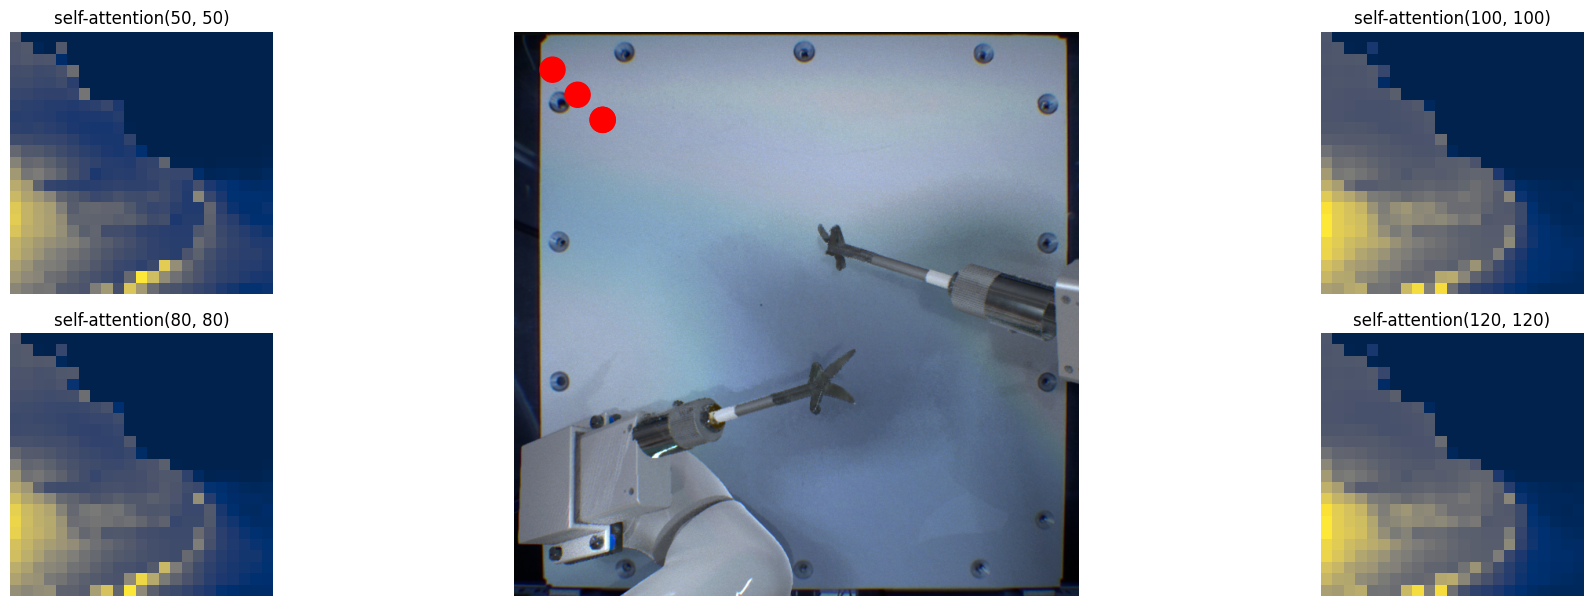

In [27]:

# output of the CNN
f_map = conv_features['0']
print("Encoder attention:      ", enc_attn_weights[0].shape)
print("Feature map:            ", f_map.tensors.shape)


# get the HxW shape of the feature maps of the CNN
shape = f_map.tensors.shape[-2:]
# and reshape the self-attention to a more interpretable shape
sattn = enc_attn_weights[0].reshape(shape + shape)
print("Reshaped self-attention:", sattn.shape)



# downsampling factor for the CNN, is 32 for DETR and 16 for DETR DC5
fact = 32

# let's select 4 reference points for visualization
idxs = [(50, 50), (80, 80), (100, 100), (120, 120)]


# here we create the canvas
fig = plt.figure(constrained_layout=True, figsize=(25 * 0.7, 8.5 * 0.7))
# and we add one plot per reference point
gs = fig.add_gridspec(2, 4)
axs = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[0, -1]),
    fig.add_subplot(gs[1, -1]),
]

# for each one of the reference points, let's plot the self-attention
# for that point
for idx_o, ax in zip(idxs, axs):
    idx = (idx_o[0] // fact, idx_o[1] // fact)
    ax.imshow(sattn[..., idx[0], idx[1]].detach().cpu().numpy(), cmap='cividis', interpolation='nearest')
    ax.axis('off')
    ax.set_title(f'self-attention{idx_o}')


# and now let's add the central image, with the reference points as red circles
fcenter_ax = fig.add_subplot(gs[:, 1:-1])
fcenter_ax.imshow(im)
for (y, x) in idxs:
    scale = im.height / img.shape[-2]
    x = ((x // fact) + 0.5) * fact
    y = ((y // fact) + 0.5) * fact
    fcenter_ax.add_patch(plt.Circle((x * scale, y * scale), fact // 2, color='r'))
    fcenter_ax.axis('off')


plt.show()

In [28]:
import io
import math  # math 모듈 추가
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import torch
from PIL import Image

class AttentionVisualizer:
    def __init__(self, model, transform, image_path=None, device='cuda'):
        self.model = model
        self.transform = transform
        self.image_path = image_path
        self.device = device  # 추가된 부분: device 설정

        self.pil_img = None
        self.tensor_img = None

        self.conv_features = None
        self.enc_attn_weights = None
        self.dec_attn_weights = None

        if self.image_path:
            self.load_image(self.image_path)

        self.setup_widgets()

    def setup_widgets(self):
        self.sliders = [
            widgets.FloatSlider(min=0, max=0.99,
                        step=0.02, description='X coordinate', value=0.72,
                        continuous_update=False,
                        layout=widgets.Layout(width='50%')
                        ),
            widgets.FloatSlider(min=0, max=0.99,
                        step=0.02, description='Y coordinate', value=0.40,
                        continuous_update=False,
                        layout=widgets.Layout(width='50%')),
            widgets.Checkbox(
              value=False,
              description='Direction of self attention',
              disabled=False,
              indent=False,
              layout=widgets.Layout(width='50%'),
          ),
            widgets.Checkbox(
              value=True,
              description='Show red dot in attention',
              disabled=False,
              indent=False,
              layout=widgets.Layout(width='50%'),
          )
        ]
        self.o = widgets.Output()

    def load_image(self, image_path):
        self.pil_img = Image.open(image_path)
        self.tensor_img = self.transform(self.pil_img).unsqueeze(0).to(self.device)  # CPU에서 GPU로 이동
        self.compute_features(self.tensor_img)

    def compute_features(self, img):
        model = self.model
        conv_features, enc_attn_weights, dec_attn_weights = [], [], []

        hooks = [
            model.backbone[-2].register_forward_hook(
                lambda self, input, output: conv_features.append(output)
            ),
            model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
                lambda self, input, output: enc_attn_weights.append(output[1])
            ),
            model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
                lambda self, input, output: dec_attn_weights.append(output[1])
            ),
        ]
        outputs = model(img)

        for hook in hooks:
            hook.remove()

        self.conv_features = conv_features[0]
        self.dec_attn_weights = dec_attn_weights[0]
        shape = self.conv_features['0'].tensors.shape[-2:]
        self.enc_attn_weights = enc_attn_weights[0].reshape(shape + shape)

    def update_chart(self, change=None):
        with self.o:
            clear_output()

            if self.pil_img is None or self.tensor_img is None:
                print("No image loaded.")
                return

            j, i, sattn_dir, sattn_dot = [s.value for s in self.sliders]

            fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(9, 4))

            j = int(j * self.tensor_img.shape[-1])
            i = int(i * self.tensor_img.shape[-2])

            scale = self.pil_img.height / self.tensor_img.shape[-2]

            sattn = self.enc_attn_weights
            fact = 2 ** round(math.log2(self.tensor_img.shape[-1] / sattn.shape[-1]))

            x = ((j // fact) + 0.5) * fact
            y = ((i // fact) + 0.5) * fact

            axs[0].imshow(self.pil_img)
            axs[0].axis('off')
            axs[0].add_patch(plt.Circle((x * scale, y * scale), fact // 2, color='r'))

            idx = (i // fact, j // fact)

            if sattn_dir:
                sattn_map = sattn[idx[0], idx[1], ...]
            else:
                sattn_map = sattn[..., idx[0], idx[1]]

            axs[1].imshow(sattn_map.detach().cpu().numpy(), cmap='cividis', interpolation='nearest')
            if sattn_dot:
                axs[1].add_patch(plt.Circle((idx[1], idx[0]), 1, color='r'))
            axs[1].axis('off')
            axs[1].set_title(f'self-attention{(i, j)}')

            plt.show()

    def run(self):
        for s in self.sliders:
            s.observe(self.update_chart, 'value')
        self.update_chart(None)

        controls = widgets.VBox(self.sliders + [self.o])
        display(controls)


In [29]:
# 이미지 경로 설정
image_path = r'F:\YOON\Datasets\jaxa_datasets\synthetic\new\random_30000\detr_dataset\images\39.png'

# AttentionVisualizer 인스턴스 생성 및 이미지 경로 전달
visualizer = AttentionVisualizer(model, transform=T.Compose([
    # T.Resize(1000),
    T.ToTensor(),
    T.Normalize([0.3369, 0.3866, 0.4526], [0.1927, 0.2150, 0.2402])
]), image_path=image_path, device='cuda')

# Visualizer 실행
visualizer.run()


FileNotFoundError: [Errno 2] No such file or directory: 'F:\\YOON\\Datasets\\jaxa_datasets\\synthetic\\new\\random_30000\\detr_dataset\\images\\39.png'

In [30]:
display(visualizer.run())

NameError: name 'visualizer' is not defined